# Alanine Multistate
## Example Simulation

This uses the state definition from [1]. 6 states named A,B,C,D,E and F


[1] W.-N. Du, K. A. Marino, and P. G. Bolhuis, “Multiple state transition interface sampling of alanine dipeptide in explicit solvent,” J. Chem. Phys., vol. 135, no. 14, p. 145102, 2011.

### Import and general setup

First we tell the ipython notebook to put figures inside the notebook

In [1]:
%matplotlib inline

And import lots of modules

In [2]:
# standard packages
import numpy as np
import mdtraj as md
import pandas as pd
import math
import random
import time

# helpers for phi-psi plotting
import alatools as ala
import matplotlib.pyplot as plt

# OpenMM
from simtk.openmm import app
import simtk.openmm as mm
import simtk.unit as unit

# OpenPathSampling
import openpathsampling as paths

# Visualization of PathTrees
from openpathsampling.visualize import PathTree
from IPython.display import SVG

# the openpathsampling OpenMM engine
import openpathsampling.engines.openmm as peng

### Set simulation options and create a simulator object

Create an AlanineOpenMMSimulator for demonstration purposes

We will need a `openmm.System` object and an `openmm.Integrator` object.

To learn more about OpenMM, read the [OpenMM documentation](http://docs.openmm.org). The code we use here is based on output from the convenient web-based [OpenMM builder](http://builder.openmm.org).

We first create a snapshot using an existing PDB file. The contained topology is necessary for the OpenMM system object to compute all forces.

In [3]:
template = peng.snapshot_from_pdb("../data/Alanine_solvated.pdb")

##### 1. the force field

using AMBER96 as in the original paper with Tip3P water.

In [4]:
forcefield = app.ForceField('amber96.xml', 'tip3p.xml')

##### 2. the system object

and we use the template to create the necessary OpenMM `Topology` object. Note that an openmm topology is (a little bit) different from an `mdtraj.Topology` so we need to convert.

In [5]:
pdb = app.PDBFile("../data/Alanine_solvated.pdb")

system = forcefield.createSystem(
    pdb.topology, 
    nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*unit.nanometers,
    constraints=app.HBonds, 
    rigidWater=True,
    ewaldErrorTolerance=0.0005
)

##### 3. the integrator

In [6]:
integrator = mm.LangevinIntegrator(
    300 * unit.kelvin,         # temperature
    1.0 / unit.picoseconds,    # friction coefficient
    2.0 * unit.femtoseconds    # integration step size
)
integrator.setConstraintTolerance(0.00001)

##### 4. the platform

we chose OpenCL on GPU for this, but you are free to choose `CPU` instead. If properly installed you can also use `CUDA`. See the OpenMM documentation or details on how to do so. 

In [7]:
platform = 'OpenCL'

##### 5. OpenMM options

There are lots of options. For speed we pick mixed precision on GPUs. Most GPU programming libraries have difficulty with double precision. For our purposes this should be fine and it is faster than double precision. These are the options passed 

In [8]:
omm_properties = {'OpenCLPrecision': 'mixed'}

##### 6. OPS options

An engine in OpenPathSampling also has options that can be set. 

In [9]:
engine_options = {
    'n_frames_max': 2000,
    'platform': platform,
    'nsteps_per_frame': 10
}

Finally build the main engine from the parts

In [10]:
engine = peng.Engine(
    template.topology, 
    system, 
    integrator, 
    properties=omm_properties,
    options=engine_options
)
engine.name = 'default'

For the exploration of state space and getting an initial trajectory we also want to simulate at a very high temperature. Here 750K. This is totally unphysical, but all we want is to generate conformations that are not completely wrong in the sense that they could exist at low temperatures.

Set a high temperature simulation for exploration.

For OpenMM all we need to change is the replace the integrator with a new temperature and half the stepsize. We will later pick only every second frame

In [11]:
integrator_high = mm.LangevinIntegrator(
    1000 * unit.kelvin,         # temperature
    1.0 / unit.picoseconds,    # friction coefficient
    1.0 * unit.femtoseconds    # integration step size
)
integrator.setConstraintTolerance(0.00001)

In [12]:
engine_high_options = {
    'n_frames_max': 10000,
    'platform': platform,
    'nsteps_per_frame': 20
}

An clone the engine using a new integrator

In [13]:
engine_high = engine.from_new_options(
    integrator=integrator_high,
    options=engine_high_options)
engine_high.name = 'high'

For now we use the default engine at 

In [14]:
paths.EngineMover.engine = engine

### Equilibrate

Use OpenMMs integrated function to minimize structures before be start

In [15]:
# engine_high.current_snapshot = template
# engine_high.minimize()
# initial_snapshot_high = engine_high.current_snapshot

### Create the storage

We open a new empty storage

In [16]:
storage = paths.Storage("ala_mstis_bootstrap.nc", 'w')

And store both engines in it. Since these are named you can load these later using `storage.engines[name]`.

In [17]:
storage.save(engine);
storage.save(engine_high);

And store the equilibrated snapshots with names for convenience.

In [18]:
storage.tag['template'] = engine.current_snapshot
storage.tag['low_template'] = engine.current_snapshot
storage.tag['high_template'] = engine_high.current_snapshot

### State Definitions

We define states A-F and $\alpha$ and $\beta$ although we will use the 6 state definition mostly. The specifications are taken from the paper.

The list of state names

In [19]:
states = ['A', 'B', 'C', 'D', 'E', 'F']

Define the centers.

In [20]:
state_centers = {
    'A' : [-150, 150], 
    'B' : [-70, 135], 
    'C' : [-150, -65], 
    'D' : [-70, -50], 
    'E' : [50, -100], 
    'F' : [40, 65]
}

And the radii of the interfaces

In [21]:
interface_levels = {
    'A' : [10, 20, 45, 65, 80],
    'B' : [10, 20, 45, 65, 75],
    'C' : [10, 20, 45, 60],
    'D' : [10, 20, 45, 60],
    'E' : [10, 20, 45, 65, 80],
    'F' : [10, 20, 45, 65, 80],
}

And also save these information for later convenience

In [22]:
storage.tag['states'] = states
storage.tag['state_centers'] = state_centers
storage.tag['interface_levels'] = interface_levels

### Order Parameters

this generates an order parameter (callable) object named psi (so if we call `psi(trajectory)` we get a list of the values of psi for each frame in the trajectory). This particular order parameter uses mdtraj's compute_dihedrals function, with the atoms in psi_atoms.

The `.with_diskcache` will tell the CVs to also create some space to save the values of this CV in the same storage where the CV gets saved. Usually you want to save the _direct_ CVs with diskcache while CVs that build upon these CVs should be fine. The reason is this:

Loading large snapshots from disk is expensive, while compute something from snapshots in memory is fast. So for analysis re-computing values is fine as long as we do not need to reload the snapshots into memory. In our case this means that the _direct_ CVs (CVs that require accessing snapshots properties) are `phi` and `psi` since everything else is based upon this, while the distance to the state center `opA` to `opF` is an _indirect_ CV and should not be stored.

In [23]:
psi_atoms = [6,8,14,16]
psi = paths.CV_MDTraj_Function(
    name="psi", 
    f=md.compute_dihedrals,
    topology=template.topology,
    indices=[psi_atoms]
).with_diskcache()

phi_atoms = [4,6,8,14]
phi = paths.CV_MDTraj_Function(
    name="phi", 
    f=md.compute_dihedrals,
    topology=template.topology,
    indices=[phi_atoms]
).with_diskcache()

storage.save([psi, phi]);

Define a function that defines a distance in periodic $\phi,\psi$-space.

In [24]:
def circle_degree(snapshot, center, phi, psi):
    import math
    degrees = 180/3.14159    
    psi_deg = psi(snapshot) * degrees
    phi_deg = phi(snapshot) * degrees
    return math.sqrt(
            ( min( phi_deg - center[0], 360 - phi_deg + center[0])**2 + 
              min( psi_deg - center[1], 360 - psi_deg + center[1])**2)
             )

Create CVs for all states

In [25]:
cv_state = dict()
for state in state_centers:
    op = paths.CV_Function(
        name = 'op' + state,
        f=circle_degree,
        center=state_centers[state],
        psi=psi,
        phi=phi
    )
    cv_state[state] = op

### Volumes

Volume define regions in state space using given CVs. We define here the regions around the state centers. Their boundaries correspond to the interfaces as used for TIS. Crossing an interface thus corresponds to leaving an interface volume into the next larger one.

In [26]:
interface_list = {}
for state, levels in interface_levels.iteritems():
    interface_list[state] = [None] * len(levels)
    for idx, level in enumerate(levels):
        interface_list[state][idx] = \
            paths.CVRangeVolume(cv_state[state], lambda_max=level)

        interface_list[state][idx].name = state + str(idx)

Create `Volume` objects for all states. The state definition is actually the lowest interface volume.

In [27]:
vol_state = {state : interface_list[state][0] for state in interface_list}

### Visualize in Phi/Psi space

We use a littl helper function specific for phi/psi plots to illustrate what is happening.
This code will not affect the generation of data but will help in visualizing the
system

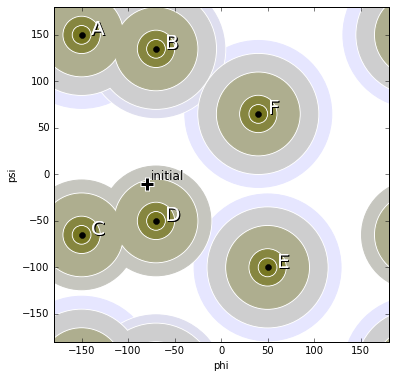

In [28]:
reload(ala)
plot = ala.TwoCVSpherePlot(
    cvs=(phi, psi),
    states=[vol_state[vol] for vol in states],
    state_centers=[state_centers[vol] for vol in states],
    interface_levels=[interface_levels[vol] for vol in states]
)

plot.new()
# plot the phi/psi plot and show all states and interfaces
plot.main()
# add the initial template
plot.add_snapshot(template, label='initial')

### Set up the MSTIS network

We want to simulate using multistate transition interface sampling and to alleviate
the effort of setting up all states, interfaces, appropriate pathensembles and
a scheme on how to generate samples we use some helper construct like in the other
examples. In our case the `MSTISNetwork` comes first and contains the definitions of
all states, their interfaces as well as associated CVs.

In [29]:
mstis = paths.MSTISNetwork([
    (
        vol_state[state],           # the core
        interface_list[state][0:],  # the list of interface
        cv_state[state]             # the associated CV
    ) for state in states
])

And save the network

In [30]:
storage.tag['network'] = mstis

### Set up the `MoveScheme`

Next, we need to specify the actual way in which we want to simulate the Network. This could be done by 
constructing a suitable PathMover yourself or employing the power of a MoveScheme that will generate all nevessary movers for you. The MoveScheme also effectively knows which initial samples in which ensembles you need. Beside the ones indirectly defined by the network the movescheme might not need some of these because certain moves will not be used. It could also happen that a movescheme require an `extra` ensemble to work for special moves that are not directly known from the network definition.

In our case we will use the `DefaultScheme` that uses RepEx, Reversal, Shooting and MinusMoves.

In [31]:
scheme = paths.DefaultScheme(mstis)

### Initial trajectories

Next, we want to generate initial pathways for all ensembles, e.g. The `TISEnsembles` and `MinusInterfaceEnsembles`. There are several ways to do so. A very easy approach is to explore the state space at a high temperature and wait until all states have been visited. Splitting the long trajectory appropriately would give us at least one valid trajectory for each TIS ensemble. In a second step we can use over sub parts of the long trajectory and extend these into minus ensembles.

So let's try this: We generate an ensemble that is `True` if a trajectory is at least completely outside one state A-F. It will report false once all states have been hit, which is what we want. We will ues this as a stopping condition to generate a first long trajectory at high temperature.

In [32]:
hit_all_states_emsemble = paths.join_ensembles([paths.AllOutXEnsemble(vol_state[state]) for state in states])

Note that we can omit the `.can_append` here since these are identical in their result and this is faster.

In [33]:
# initial_trajectories = engine_high.generate(template, [hit_all_states])

This step would take a long time for we will get stuck in the cores most of the time. To avoid losing this much time we do a little trick to get trajectories faster to connect all states: We will generate an ensemble the represents trajectories that bounce between all cores: Run until we hit any core, save the trajectory, reverse velocities and run again. This way we collect inter-state trajectories and once we have seen all states we stop.

For `MSTISNetwork`s there exists a function that does exactly that. You specify one initial snapshot and an engine to be used and it will bounce between the defined states and return a list of samples that represent the inter-state trajectories. It does some nice progress report, too.

In [34]:
initial_trajectories = mstis.generate_inter_state_samples(template, engine_high)

       TOTAL FRAMES [ 21115] // missing: [  ]
----------------------------
[ 825]  A0 ->  B0   [    34]
[ 826]  B0 ->  A0   [    12]
[ 827]  A0 ->  A0   [    41]
[ 828]  A0 ->  A0   [   108]
[ 829]  A0 ->  E0   [   130]
[ 830]  E0 ->  D0   [   187]
[ 831]  D0 ->  D0   [     9]
[ 832]  E0 ->  B0   [    75]
[ 833]  E0 ->  E0   [    16]
[ 834]  E0 ->  E0   [    53]

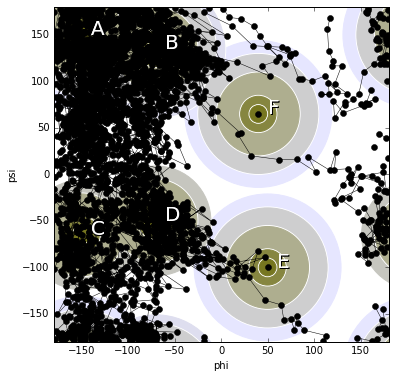

In [46]:
reload(ala)

plot.new()
plot.main()
# add the initial template
for traj in initial_trajectories[0:100]:
    plot.add_trajectory(traj)

### Find initial samples 

It can be difficult to get initial samples for an ensemble for various reasons. In theory you could just pick a frame and extend forward and backward until an ensemble reports cannot append anymore and check if that sample is in the ensemble. While this works in many cases it can be rather inefficient. For us it is better to reuse the previously computed trajectories as a basis to generate samples.

To do so, we use a function from `Ensemble` that will try to generate a sample from a list of initial trajectories: This function will scan the given list for useful parts: 

1. complete trajectories that fit the ensemble
2. trajectories that can be extended into one that fits the ensemble.
3. check also reversed versions of the given trajectories

All that is left to do is to loop over all ensembles that need to be filled and try to generate a sample. This is what the next function does: Check the `mstis` object for all necessary ensembles and try the above on all of them using all samples we have found so far.

In [35]:
total_sample_set = paths.SampleSet.generate_from_trajectories(
    scheme.list_initial_ensembles(),
    initial_trajectories,     
    engine_high)

Successfully generated initial sampleset with 29 samples

Done.

## Equilibration

In molecular dynamics, you need to equilibrate if you don't start with an equilibrium frame (e.g., if you start with solvent molecules on a grid, your system should equilibrate before you start taking statistics). Similarly, if you start with a set of paths which are far from the path ensemble equilibrium, you need to equilibrate. This could either be because your trajectories are not from the real dynamics (generated with metadynamics, high temperature, etc.) or because your trajectories are not likely representatives of the path ensemble (e.g., if you put transition trajectories into all interfaces).

As with MD, running equilibration can be the same process as running the total simulation. However, in path sampling, it doesn't have to be: we can equilibrate without replica exchange moves or path reversal moves, for example. In the example below, we create a `MoveScheme` that only includes shooting movers.

In [36]:
equil_scheme = paths.MoveScheme(mstis)

# tell the scheme to actually use OneWayShooting and nothing else
import openpathsampling.analysis.move_strategy as strat
equil_scheme.append([
        strat.OneWayShootingStrategy(engine=engine), 
        strat.OrganizeByMoveGroupStrategy()
    ])

Note, that some Schemes may change the actual required set of initial samples. For
the equilibration we apply shooting moves only to TIS ensembles and not to the
`MinusInterfaceEnsemble`s.

Create the PathSampler object that can run the equilibration.

In [37]:
equilibration = paths.PathSampling(
    storage=None,
    globalstate=total_sample_set,
    move_scheme=equil_scheme,
)

And run lots of equilibration steps. This is not really necessary, but
we generated from the wrong path distribution and this should give more likeli
paths for the right temperature.

In [38]:
equilibration.run(250)
equilibrated_sset = equilibration.globalstate

Working on Monte Carlo cycle number 250
Running for 654 seconds -  0.38 steps per second
Expected time to finish: 2 seconds
DONE! Completed 250 Monte Carlo cycles.


Let's have a quick look how many frames in TIS ensembles are already generated by the default engine.

In [39]:
engine_list = {}

unique_snapshots = set(sum(
    [
        samp.trajectory for samp in equilibrated_sset 
        if isinstance(samp.ensemble, paths.TISEnsemble)
    ], 
    []))

for samp in equilibrated_sset:
    if isinstance(samp.ensemble, paths.TISEnsemble):
        for snap in samp.trajectory:
            eng = snap.engine
            engine_list[eng] = engine_list.get(eng, 0) + 1
        
for eng, counts in engine_list.items():
    print eng.name, counts

high 107
default 1426


Finally, save the list of samples for later without any reference to previous samples. This saves storage.

In [40]:
storage.tag['sampleset'] = equilibrated_sset.copy_without_parents()

Let's have a final look at what we cover with all our initial samples.

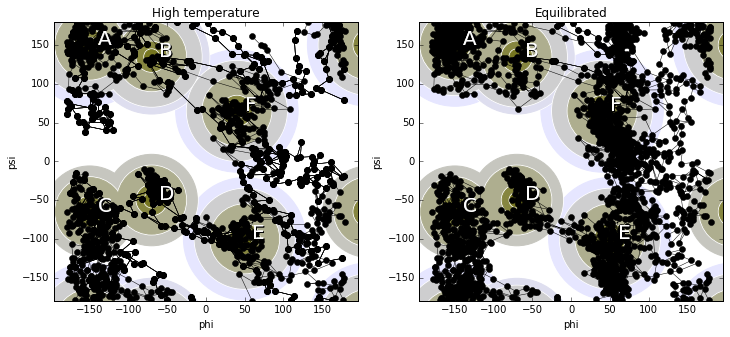

In [41]:
plt.figure(21, (12,5))
plt.subplot(121)
plt.title('High temperature')
plot.main()
for s in total_sample_set:
    plot.add_trajectory(s.trajectory, line=True)
    
plt.subplot(122)
plt.title('Equilibrated')
plot.main()
plot.zoom = 180/3.1415926
for s in equilibrated_sset:
    plot.add_trajectory(s.trajectory, line=True)

A final check that we still have a valid sampleset

In [42]:
equilibrated_sset.sanity_check()

In [43]:
print 'snapshots:', len(storage.snapshots)
print 'trajectories:', len(storage.trajectories)
print 'samples:', len(storage.samples)
print 'filesize:', storage.file_size_str

snapshots: 5554
trajectories: 51
samples: 29
filesize: 140.98MB


In [49]:
storage.close()